<a href="https://colab.research.google.com/github/yalinyener/TwitterSentimentAnalysis/blob/master/GoDaddy_MicrobusinessDensityForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import Libraries and Setting Defaults

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns


from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import KFold, TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize']=15,6
rcParams['figure.dpi'] = 150
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# Read csv and Create Data Frame

%cd /content/drive/My Drive/Colab Notebooks/GoDaddy-MicrobusinessDensityForecasting/Data

census= pd.read_csv("census_starter.csv")
revealed_test= pd.read_csv("revealed_test.csv")
test= pd.read_csv("test.csv")
train= pd.read_csv("train.csv")
sample_submission= pd.read_csv("sample_submission.csv")

/content/drive/My Drive/Colab Notebooks/GoDaddy-MicrobusinessDensityForecasting/Data


In [ ]:
# Review of train
print("train")
print(train.shape)
train.head()

train
(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [ ]:
# Review of test
print("test")
print(test.shape)
test.head()

test
(25080, 3)


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [ ]:
# Review of sample_submission
print("sample_submission")
print(sample_submission.shape)
sample_submission.head()

sample_submission
(25080, 2)


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


In [ ]:
# Reviwe of census
print("census")
print(census.shape)
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [ ]:
# Review of revealed_test
print("revealed_test")
print(revealed_test.shape)
revealed_test.head()

revealed_test
(6270, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [ ]:
# Checking null values and column type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [ ]:
#Convert field types
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])


In [ ]:
# Stats of int / float fields
train.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,1.222650e+05
mean,30376.037640,3.817671,6.442858e+03
std,15143.508721,4.991087,3.304001e+04
min,1001.000000,0.000000,0.000000e+00
25%,18177.000000,1.639344,1.450000e+02
50%,29173.000000,2.586543,4.880000e+02
75%,45077.000000,4.519231,2.124000e+03
max,56045.000000,284.340030,1.167744e+06


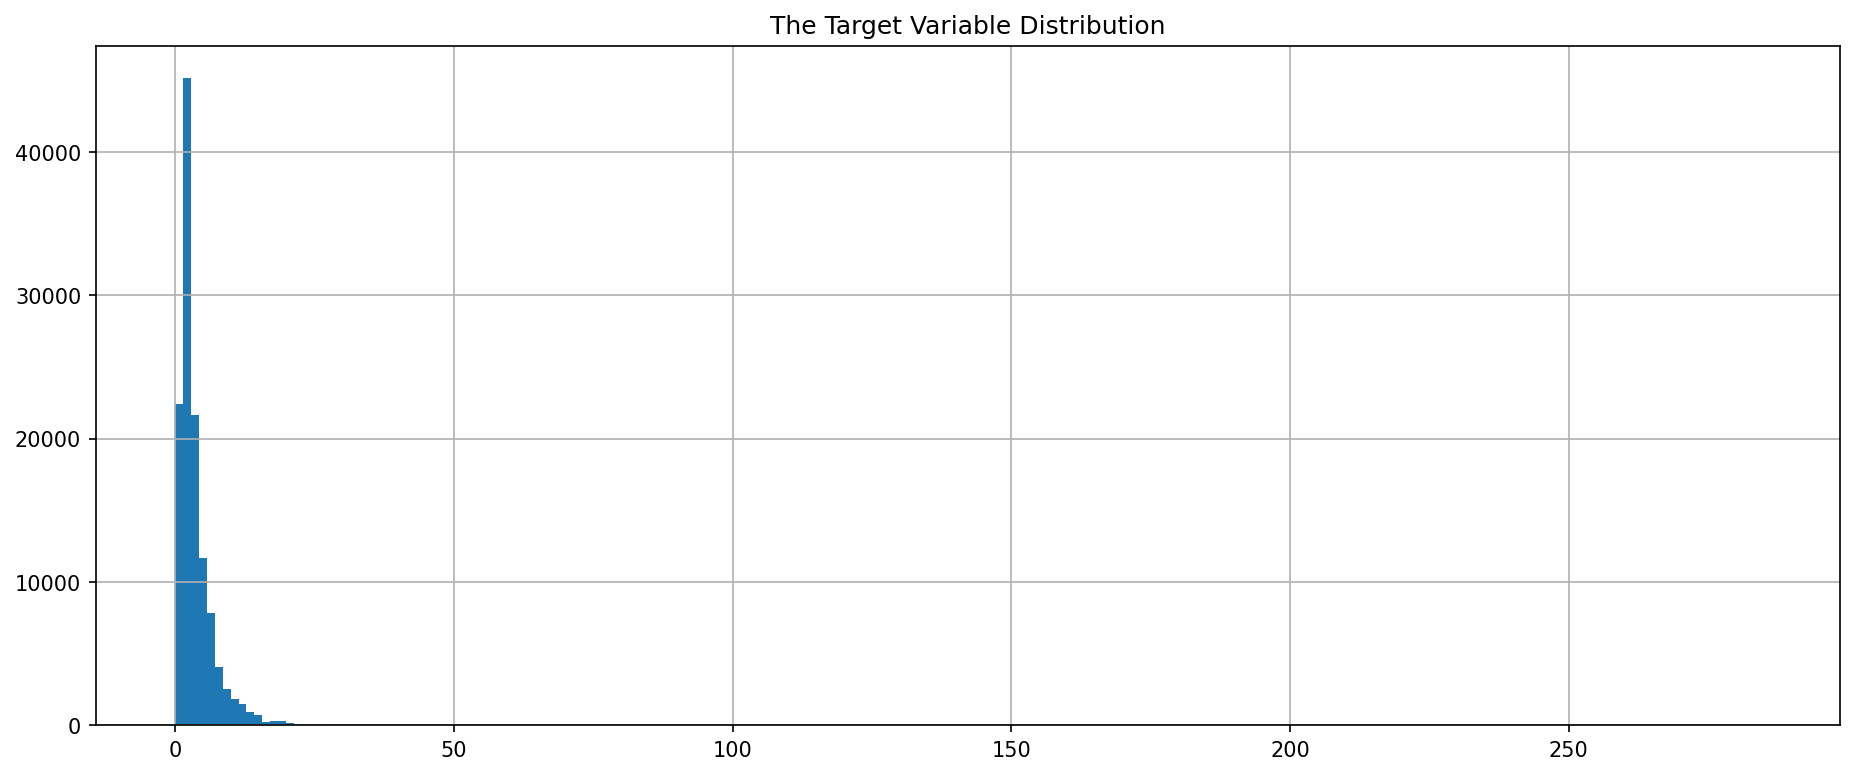

In [ ]:
# The distribution of the target variable
plt.title('The Target Variable Distribution')
train['microbusiness_density'].hist(bins=200);

In [ ]:
train['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

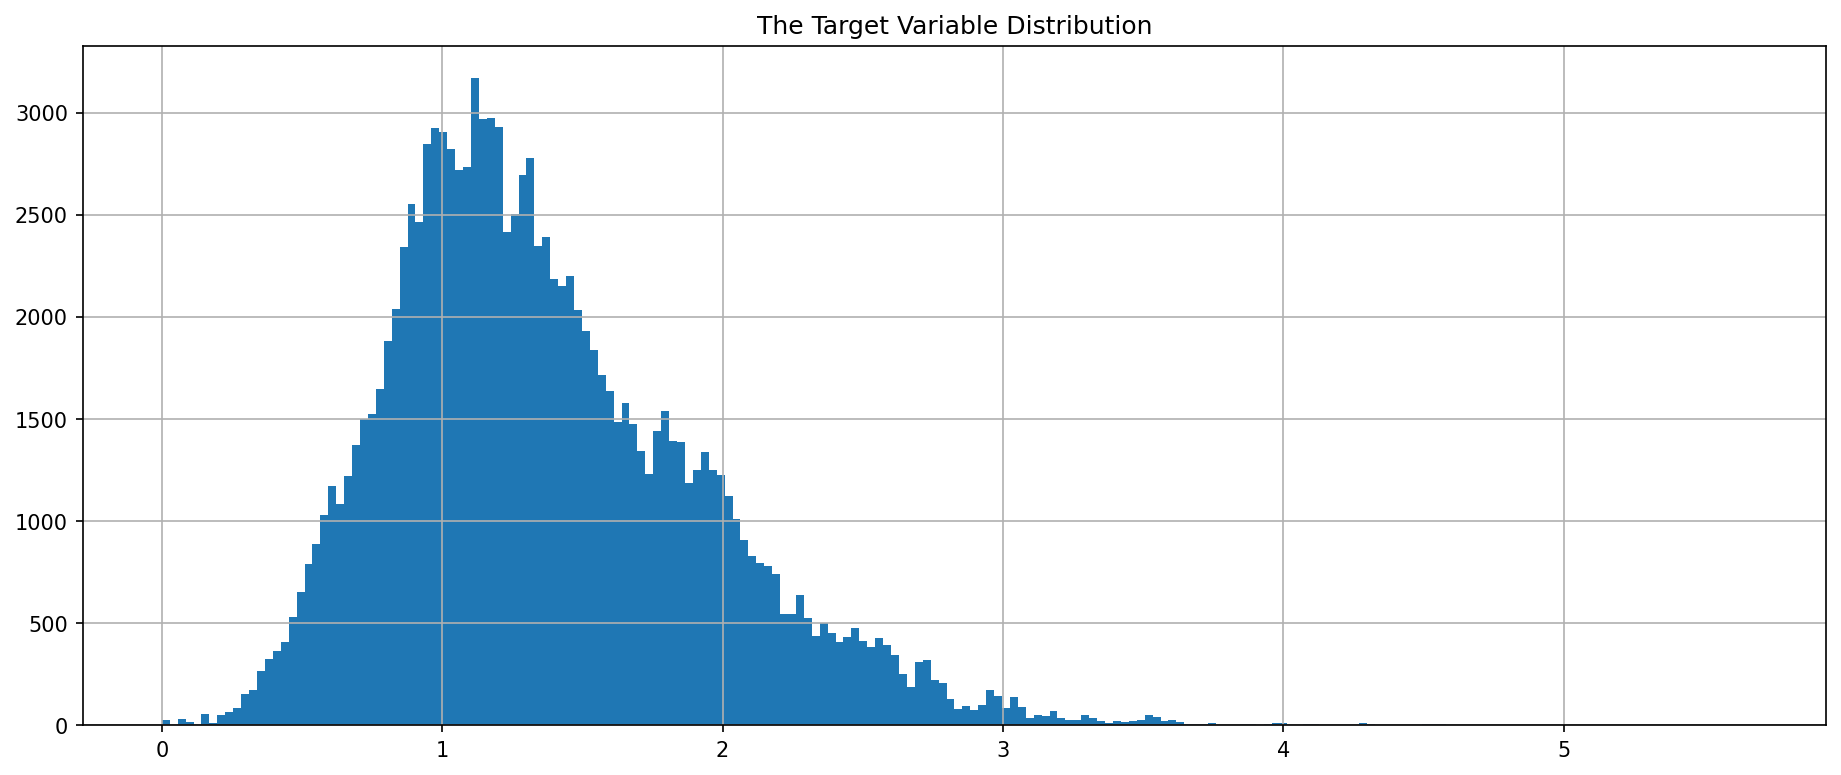

In [ ]:
# The distribution of the target variable
plt.title('The Target Variable Distribution')
np.log1p(train['microbusiness_density']).hist(bins=200);

In [ ]:
np.log1p(train['microbusiness_density']).describe()

count    122265.000000
mean          1.373774
std           0.568360
min           0.000000
25%           0.970530
50%           1.277189
75%           1.708239
max           5.653682
Name: microbusiness_density, dtype: float64

In [ ]:
train_target_df = train[['row_id', 'microbusiness_density']]


In [ ]:
train['first_day_of_month'].describe(datetime_is_numeric=True)

count                           122265
mean     2021-03-01 20:55:23.076923136
min                2019-08-01 00:00:00
25%                2020-05-01 00:00:00
50%                2021-03-01 00:00:00
75%                2022-01-01 00:00:00
max                2022-10-01 00:00:00
Name: first_day_of_month, dtype: object

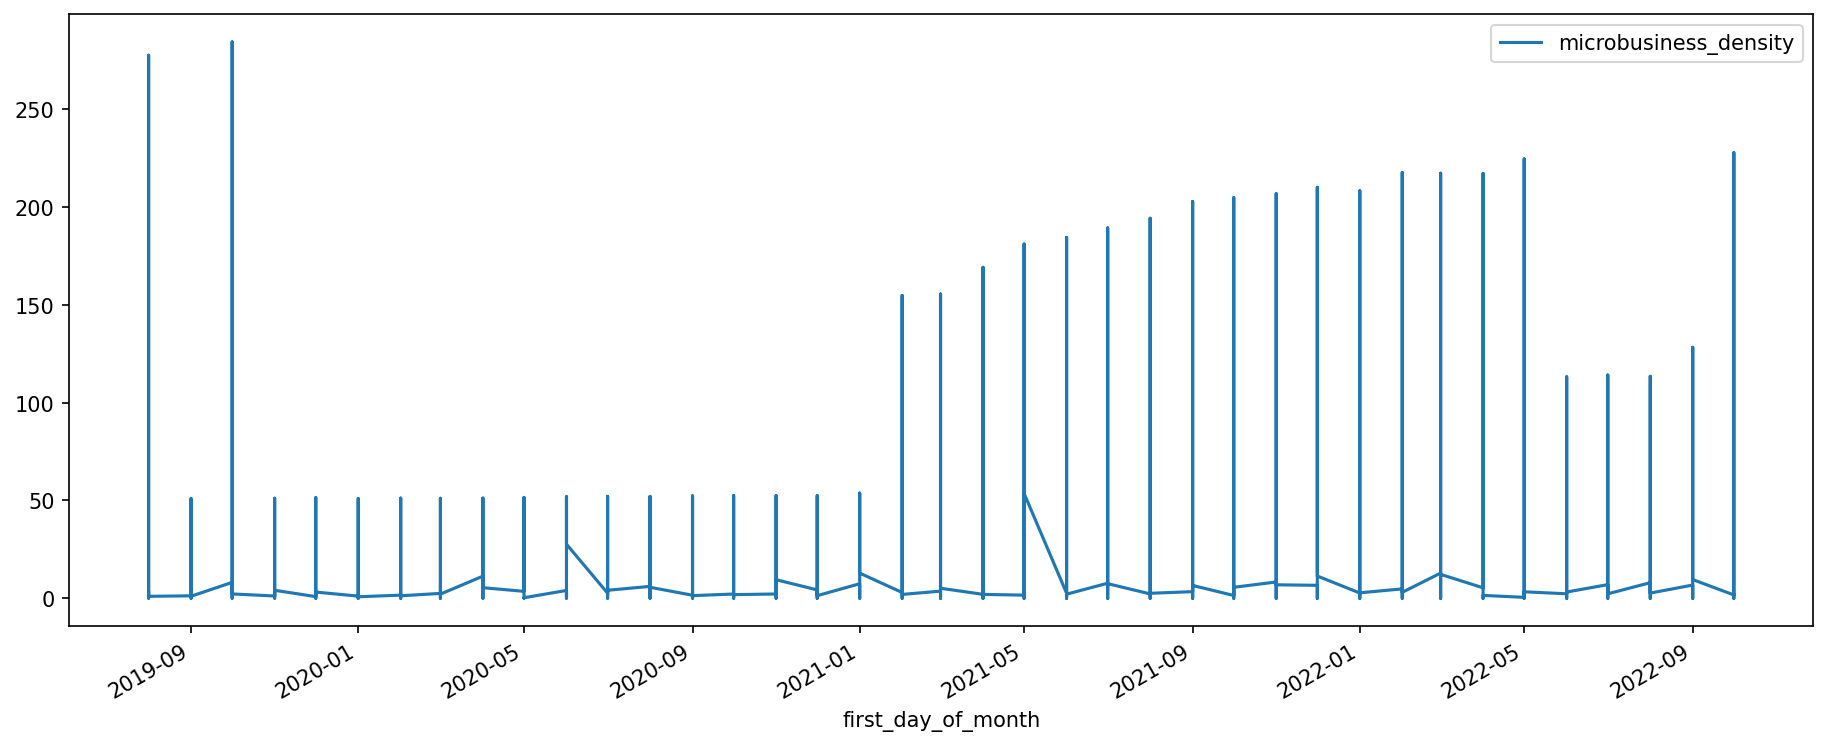

In [ ]:
train.plot( 'first_day_of_month' , 'microbusiness_density' );

In [ ]:
# Checking cfips (unique fields)
print('cfips on train data')
print(train['cfips'].nunique())

print('cfips on test data')
print(test['cfips'].nunique())

print('cfips on census data')
print(census['cfips'].nunique())

cfips on train data
3135
cfips on test data
3135
cfips on census data
3142


In [ ]:
test['cfips'].isin(train['cfips']).value_counts()

True    25080
Name: cfips, dtype: int64

In [ ]:
census['cfips'].isin(train['cfips']).value_counts()

True     3135
False       7
Name: cfips, dtype: int64

In [ ]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [ ]:
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [ ]:
#Running model with base variables

X = train[["cfips","first_day_of_month"]]
y = train['microbusiness_density']

test=test[["cfips","first_day_of_month"]]

#symmetric mean absolute error
def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

#Catboots Base
#Gradient Boosting is an ensemble machine learning algorithm and typically used for solving classification and regression problems

err_catboots_base=[]
y_pred_catboots_base=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='SMAPE')
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_catboots_base.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test)
    y_pred_catboots_base.append(p)

Learning rate set to 0.104565
0:	learn: 61.6783814	test: 61.6783814	test1: 61.6914641	best: 61.6914641 (0)	total: 33.6ms	remaining: 33.5s
100:	learn: 54.0284374	test: 54.0284374	test1: 54.2890593	best: 54.2890593 (100)	total: 1.81s	remaining: 16.1s
200:	learn: 52.6163074	test: 52.6163074	test1: 52.9352205	best: 52.9352205 (200)	total: 4.63s	remaining: 18.4s
300:	learn: 52.0548147	test: 52.0548147	test1: 52.4429142	best: 52.4429142 (300)	total: 7.11s	remaining: 16.5s
400:	learn: 51.7129092	test: 51.7129092	test1: 52.1503497	best: 52.1500924 (399)	total: 8.29s	remaining: 12.4s
500:	learn: 51.4825727	test: 51.4825727	test1: 51.9915051	best: 51.9915001 (498)	total: 9.46s	remaining: 9.42s
600:	learn: 51.3630004	test: 51.3630004	test1: 51.9286442	best: 51.9268128 (591)	total: 10.6s	remaining: 7.07s
700:	learn: 51.2617349	test: 51.2617349	test1: 51.8661992	best: 51.8661992 (700)	total: 11.8s	remaining: 5.04s
800:	learn: 51.1991601	test: 51.1991601	test1: 51.8420211	best: 51.8420211 (800)	tota

In [ ]:
np.mean(err_catboots_base)

NameError: ignored

In [ ]:
#cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

#Create new df function
def create_feature(df):
    feature = pd.DataFrame()
    feature['cfips'] = df["cfips"]
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    
    return feature

In [ ]:
#Checking feature dataframe
create_feature(train).sample(15)

,cfips,fips,county,year,month,week
115504,53031,53,31,2021,9,2
114838,51830,51,830,2021,6,1
63430,30061,30,61,2020,12,1
75408,37093,37,93,2021,5,5
106621,48429,48,429,2022,6,2
120250,55085,55,85,2020,9,1
118188,54091,54,91,2021,2,0
91611,45073,45,73,2019,8,3
22630,16063,16,63,2020,6,0
74457,37045,37,45,2020,2,5


In [ ]:
#Catboots V1

train_v1 = create_feature(train)
test_v1 = create_feature(test)

X = train_v1
y = (train['microbusiness_density'])

def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

err_catboots_v1=[]
y_pred_catboots_v1=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='SMAPE')
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_catboots_v1.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v1)
    y_pred_catboots_v1.append(p)

Learning rate set to 0.104565
0:	learn: 61.7364272	test: 61.7364272	test1: 61.7538389	best: 61.7538389 (0)	total: 66.5ms	remaining: 1m 6s
100:	learn: 52.6438485	test: 52.6438485	test1: 52.7722034	best: 52.7722034 (100)	total: 2.08s	remaining: 18.5s
200:	learn: 49.9302141	test: 49.9302141	test1: 50.1600661	best: 50.1600661 (200)	total: 3.46s	remaining: 13.8s
300:	learn: 47.8244202	test: 47.8244202	test1: 48.1361699	best: 48.1361699 (300)	total: 4.8s	remaining: 11.1s
400:	learn: 46.2390560	test: 46.2390560	test1: 46.6311500	best: 46.6311500 (400)	total: 6.24s	remaining: 9.33s
500:	learn: 44.8225587	test: 44.8225587	test1: 45.2638137	best: 45.2638137 (500)	total: 7.64s	remaining: 7.61s
600:	learn: 43.5395057	test: 43.5395057	test1: 44.0059659	best: 44.0059659 (600)	total: 9.45s	remaining: 6.27s
700:	learn: 42.4659906	test: 42.4659906	test1: 42.9837849	best: 42.9837849 (700)	total: 13.8s	remaining: 5.89s
800:	learn: 41.2732909	test: 41.2732909	test1: 41.8142835	best: 41.8142835 (800)	total

In [ ]:
#Catboost Model_v2
#Create new df function
def create_feature(df):
    feature = pd.DataFrame()
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    
    return feature

train_v2 = create_feature(train)
test_v2 = create_feature(test)

X = train_v2
y = (train['microbusiness_density'])

def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

err_catboots_v2=[]
y_pred_catboots_v2=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='SMAPE')
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_catboots_v2.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v2)
    y_pred_catboots_v2.append(p)



NameError: ignored

In [ ]:
#Mean value of errors
np.mean((err_catboots_v2))

103.92114911671862

In [ ]:
#Catboost Model_v3
#Create new df function
def create_feature(df):
    feature = pd.DataFrame()
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    
    return feature

train_v3 = create_feature(train)
test_v3 = create_feature(test)

X = train_v3
y = np.log1p(train['microbusiness_density'])

def smape(y_true, y_pred):
    nume = np.abs(y_true - y_pred)
    deno = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return 100 * np.mean(nume / deno)

err_catboots_v3=[]
y_pred_catboots_v3=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='SMAPE')
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_catboots_v3.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v3)
    y_pred_catboots_v3.append(p)

Learning rate set to 0.104565
0:	learn: 32.8151912	test: 32.8151912	test1: 32.7870064	best: 32.7870064 (0)	total: 20.9ms	remaining: 20.9s
100:	learn: 28.3780216	test: 28.3780216	test1: 28.4591724	best: 28.4591724 (100)	total: 1.33s	remaining: 11.9s
200:	learn: 27.1067729	test: 27.1067729	test1: 27.2339586	best: 27.2339586 (200)	total: 2.67s	remaining: 10.6s
300:	learn: 26.1210753	test: 26.1210753	test1: 26.2667171	best: 26.2667171 (300)	total: 5.04s	remaining: 11.7s
400:	learn: 25.3024827	test: 25.3024827	test1: 25.4815163	best: 25.4815163 (400)	total: 8s	remaining: 12s
500:	learn: 24.6336168	test: 24.6336168	test1: 24.8384132	best: 24.8384132 (500)	total: 10s	remaining: 9.99s
600:	learn: 23.9827677	test: 23.9827677	test1: 24.1908384	best: 24.1908384 (600)	total: 11.3s	remaining: 7.52s
700:	learn: 23.3556589	test: 23.3556589	test1: 23.5658753	best: 23.5658753 (700)	total: 13.5s	remaining: 5.75s
800:	learn: 22.8053927	test: 22.8053927	test1: 23.0346915	best: 23.0346915 (800)	total: 15s	

In [ ]:
#Mean value of errors
np.mean((err_catboots_v3))

38.00651642672119

In [ ]:
# LightGbm
# LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

params = {
        "metric" : "mse",
        "learning_rate" : 0.2,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
}


train_v3 = create_feature(train)
test_v3 = create_feature(test)

X = train_v3
y = np.log1p(train['microbusiness_density'])

err_lgb=[]
y_pred_lgb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_lgb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v3)
    y_pred_lgb.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.127173	valid_1's l2: 0.129982
[200]	training's l2: 0.0841505	valid_1's l2: 0.0871242
[300]	training's l2: 0.0586868	valid_1's l2: 0.0617255
[400]	training's l2: 0.0459079	valid_1's l2: 0.0492565
[500]	training's l2: 0.0371144	valid_1's l2: 0.0401899
[600]	training's l2: 0.0313129	valid_1's l2: 0.0345485
[700]	training's l2: 0.0274021	valid_1's l2: 0.0309256
[800]	training's l2: 0.0246617	valid_1's l2: 0.0282852
[900]	training's l2: 0.0226857	valid_1's l2: 0.0267677
[1000]	training's l2: 0.0212661	valid_1's l2: 0.0256419
[1100]	training's l2: 0.0202297	valid_1's l2: 0.024953
[1200]	training's l2: 0.0196143	valid_1's l2: 0.0246868
[1300]	training's l2: 0.0190053	valid_1's l2: 0.0244627
[1400]	training's l2: 0.0185122	valid_1's l2: 0.024295
[1500]	training's l2: 0.0180868	valid_1's l2: 0.0241652
[1600]	training's l2: 0.0177812	valid_1's l2: 0.0242381
Early stopping, best iteration is:
[1506]	training's l

In [ ]:
np.mean(err_lgb)

10.902938754532745

In [ ]:
# LightGbm V2
# LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

params = {
        "metric" : "mse",
        "learning_rate" : 0.2,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
}

def create_feature(df):
    feature = pd.DataFrame()
    feature["cfips"] = df["cfips"]
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    
    return feature

train_v2 = create_feature(train)
test_v2 = create_feature(test)

X = train_v2
y = np.log1p(train['microbusiness_density'])


err_lgb_v2=[]
y_pred_lgb_v2=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_lgb_v2.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v2)
    y_pred_lgb_v2.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.226976	valid_1's l2: 0.234443
Early stopping, best iteration is:
[54]	training's l2: 0.22836	valid_1's l2: 0.232452
err:  47.95412183124865
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.224954	valid_1's l2: 0.231416
Early stopping, best iteration is:
[61]	training's l2: 0.226284	valid_1's l2: 0.22997
err:  47.63140569796345
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.22621	valid_1's l2: 0.237954
Early stopping, best iteration is:
[50]	training's l2: 0.227915	valid_1's l2: 0.236129
err:  48.37768620272052
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.227823	valid_1's l2: 0.229341
Early stopping, best iteration is:
[46]	training's l2: 0.229722	valid_1's l2: 0.227662
err:  47.91390672053296
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.23341	val

In [ ]:
np.mean((err_lgb_v2))

47.975771865938995

In [ ]:
np.mean((errcb))

38.00651642672119

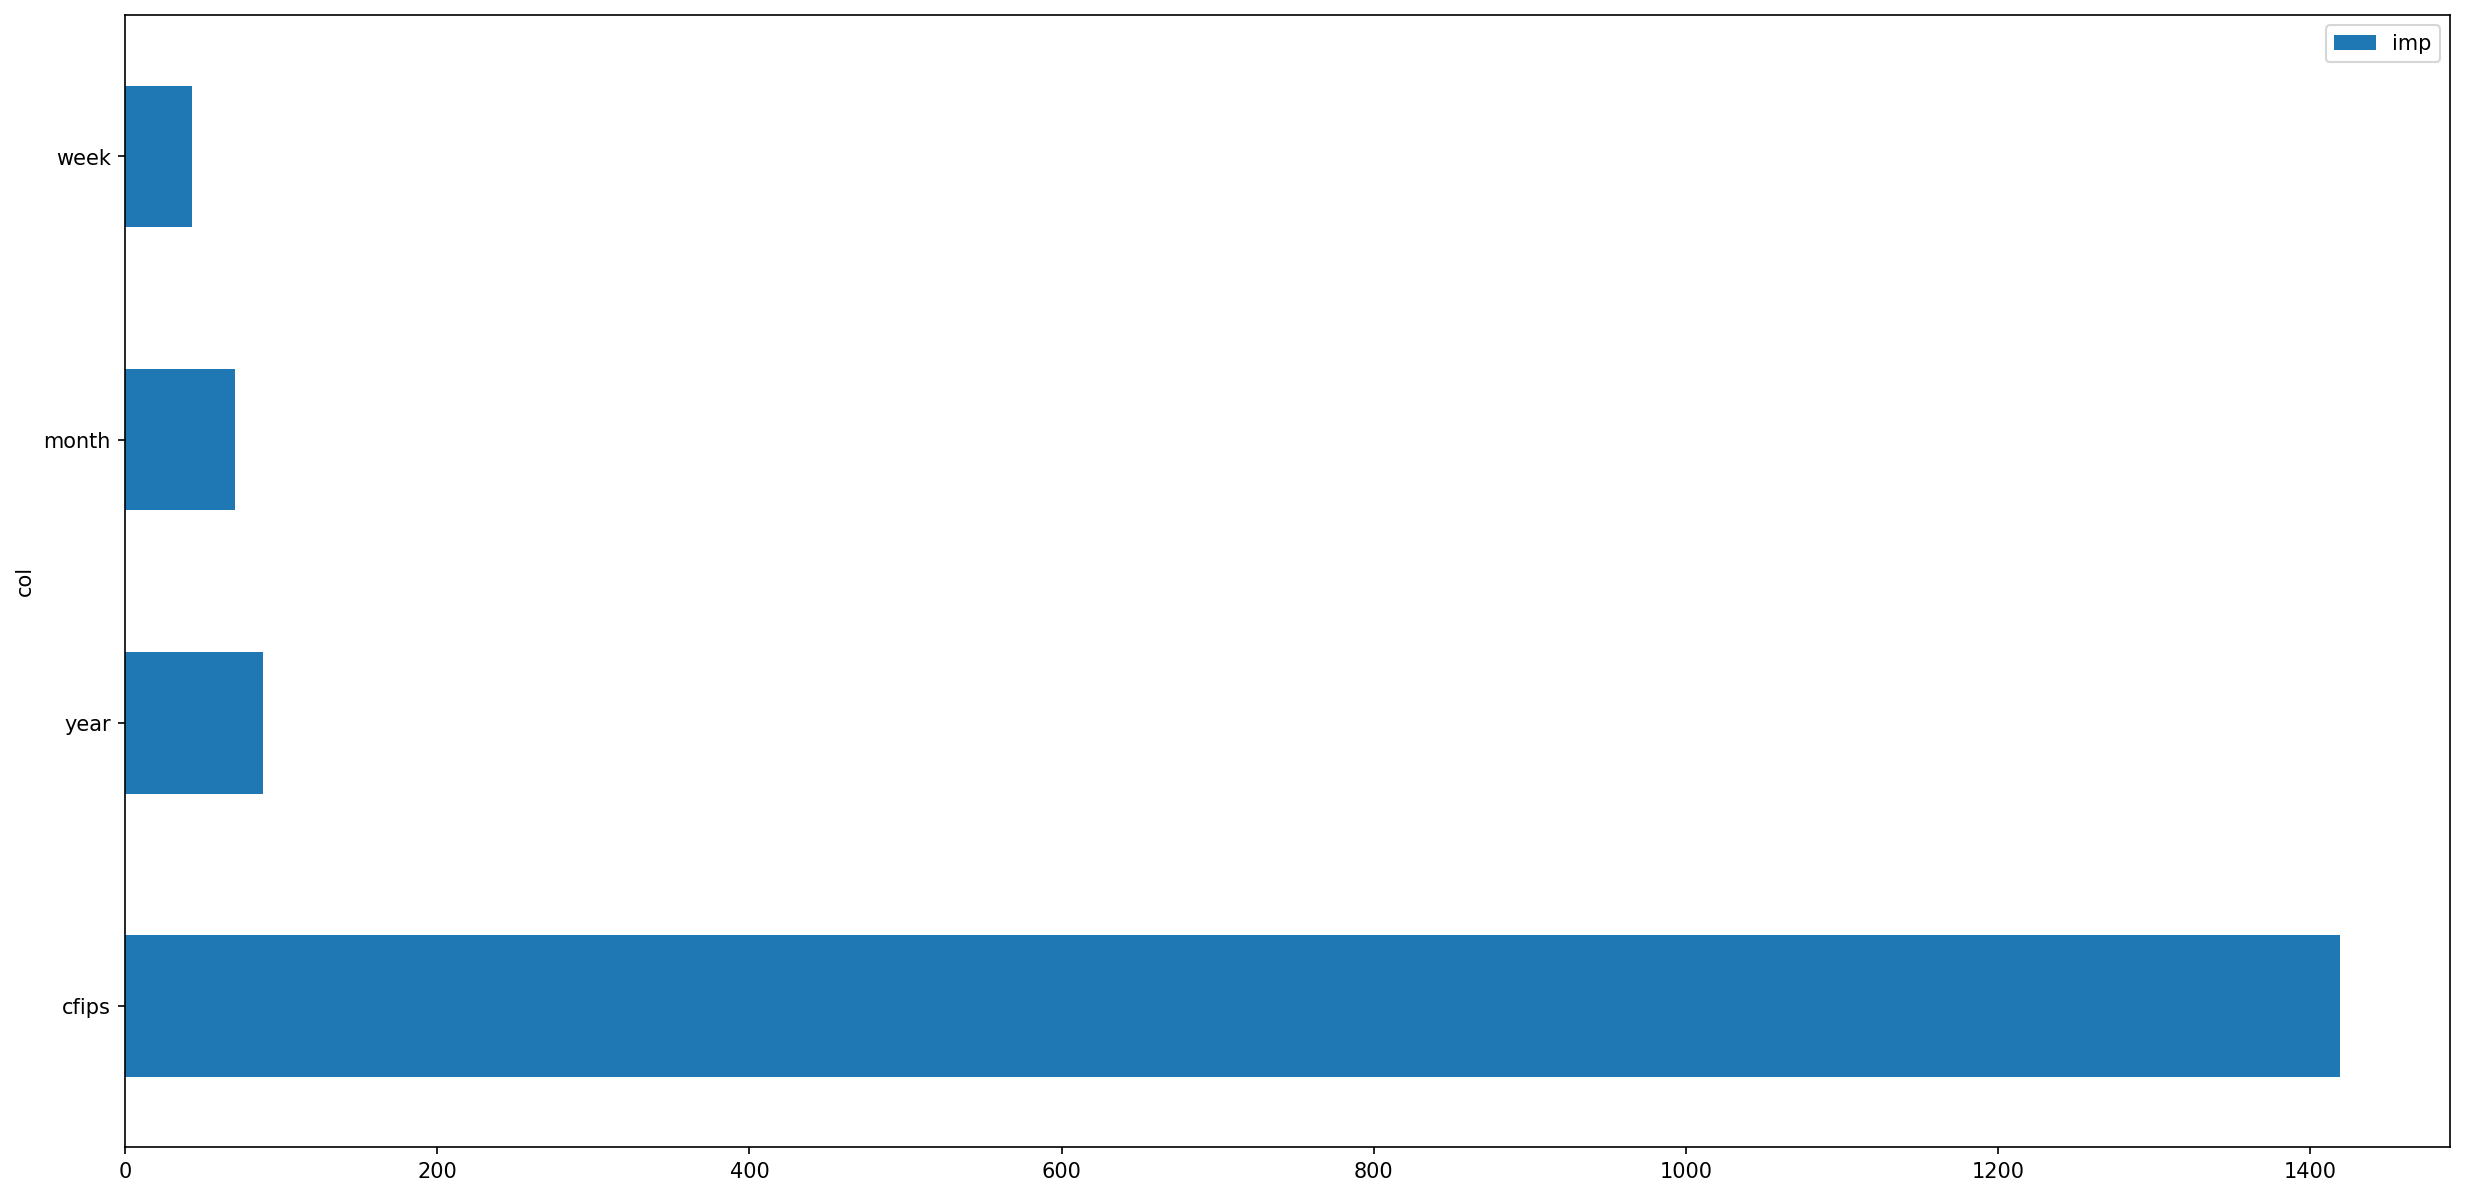

In [ ]:
#Checking feature importanca parameters of last run model
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

In [ ]:
# LightGbm V3
# LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

params = {
        "metric" : "mse",
        "learning_rate" : 0.2,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
}

def create_feature(df):
    feature = pd.DataFrame()
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    feature['dayofyear'] = df['first_day_of_month'].dt.dayofyear
    feature['dayofmonth'] = df['first_day_of_month'].dt.day
    feature['weekofyear'] = df['first_day_of_month'].dt.weekofyear
    
    return feature

train_v3 = create_feature(train)
test_v3 = create_feature(test)

X = train_v3
y = np.log1p(train['microbusiness_density'])


err_lgb_v3=[]
y_pred_lgb_v3=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_lgb_v3.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v3)
    y_pred_lgb_v3.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.127764	valid_1's l2: 0.130423
[200]	training's l2: 0.0848812	valid_1's l2: 0.0873893
[300]	training's l2: 0.0603812	valid_1's l2: 0.0637127
[400]	training's l2: 0.0466206	valid_1's l2: 0.0500626
[500]	training's l2: 0.0384508	valid_1's l2: 0.0419666
[600]	training's l2: 0.0330007	valid_1's l2: 0.0365646
[700]	training's l2: 0.0287844	valid_1's l2: 0.0325517
[800]	training's l2: 0.0250104	valid_1's l2: 0.0289966
[900]	training's l2: 0.0230819	valid_1's l2: 0.0274575
[1000]	training's l2: 0.021603	valid_1's l2: 0.0263334
[1100]	training's l2: 0.0206845	valid_1's l2: 0.0258529
[1200]	training's l2: 0.0199751	valid_1's l2: 0.025618
[1300]	training's l2: 0.0192002	valid_1's l2: 0.0251185
[1400]	training's l2: 0.0186276	valid_1's l2: 0.0249093
[1500]	training's l2: 0.0181399	valid_1's l2: 0.0246777
[1600]	training's l2: 0.0177874	valid_1's l2: 0.0246575
Early stopping, best iteration is:
[1528]	training's l

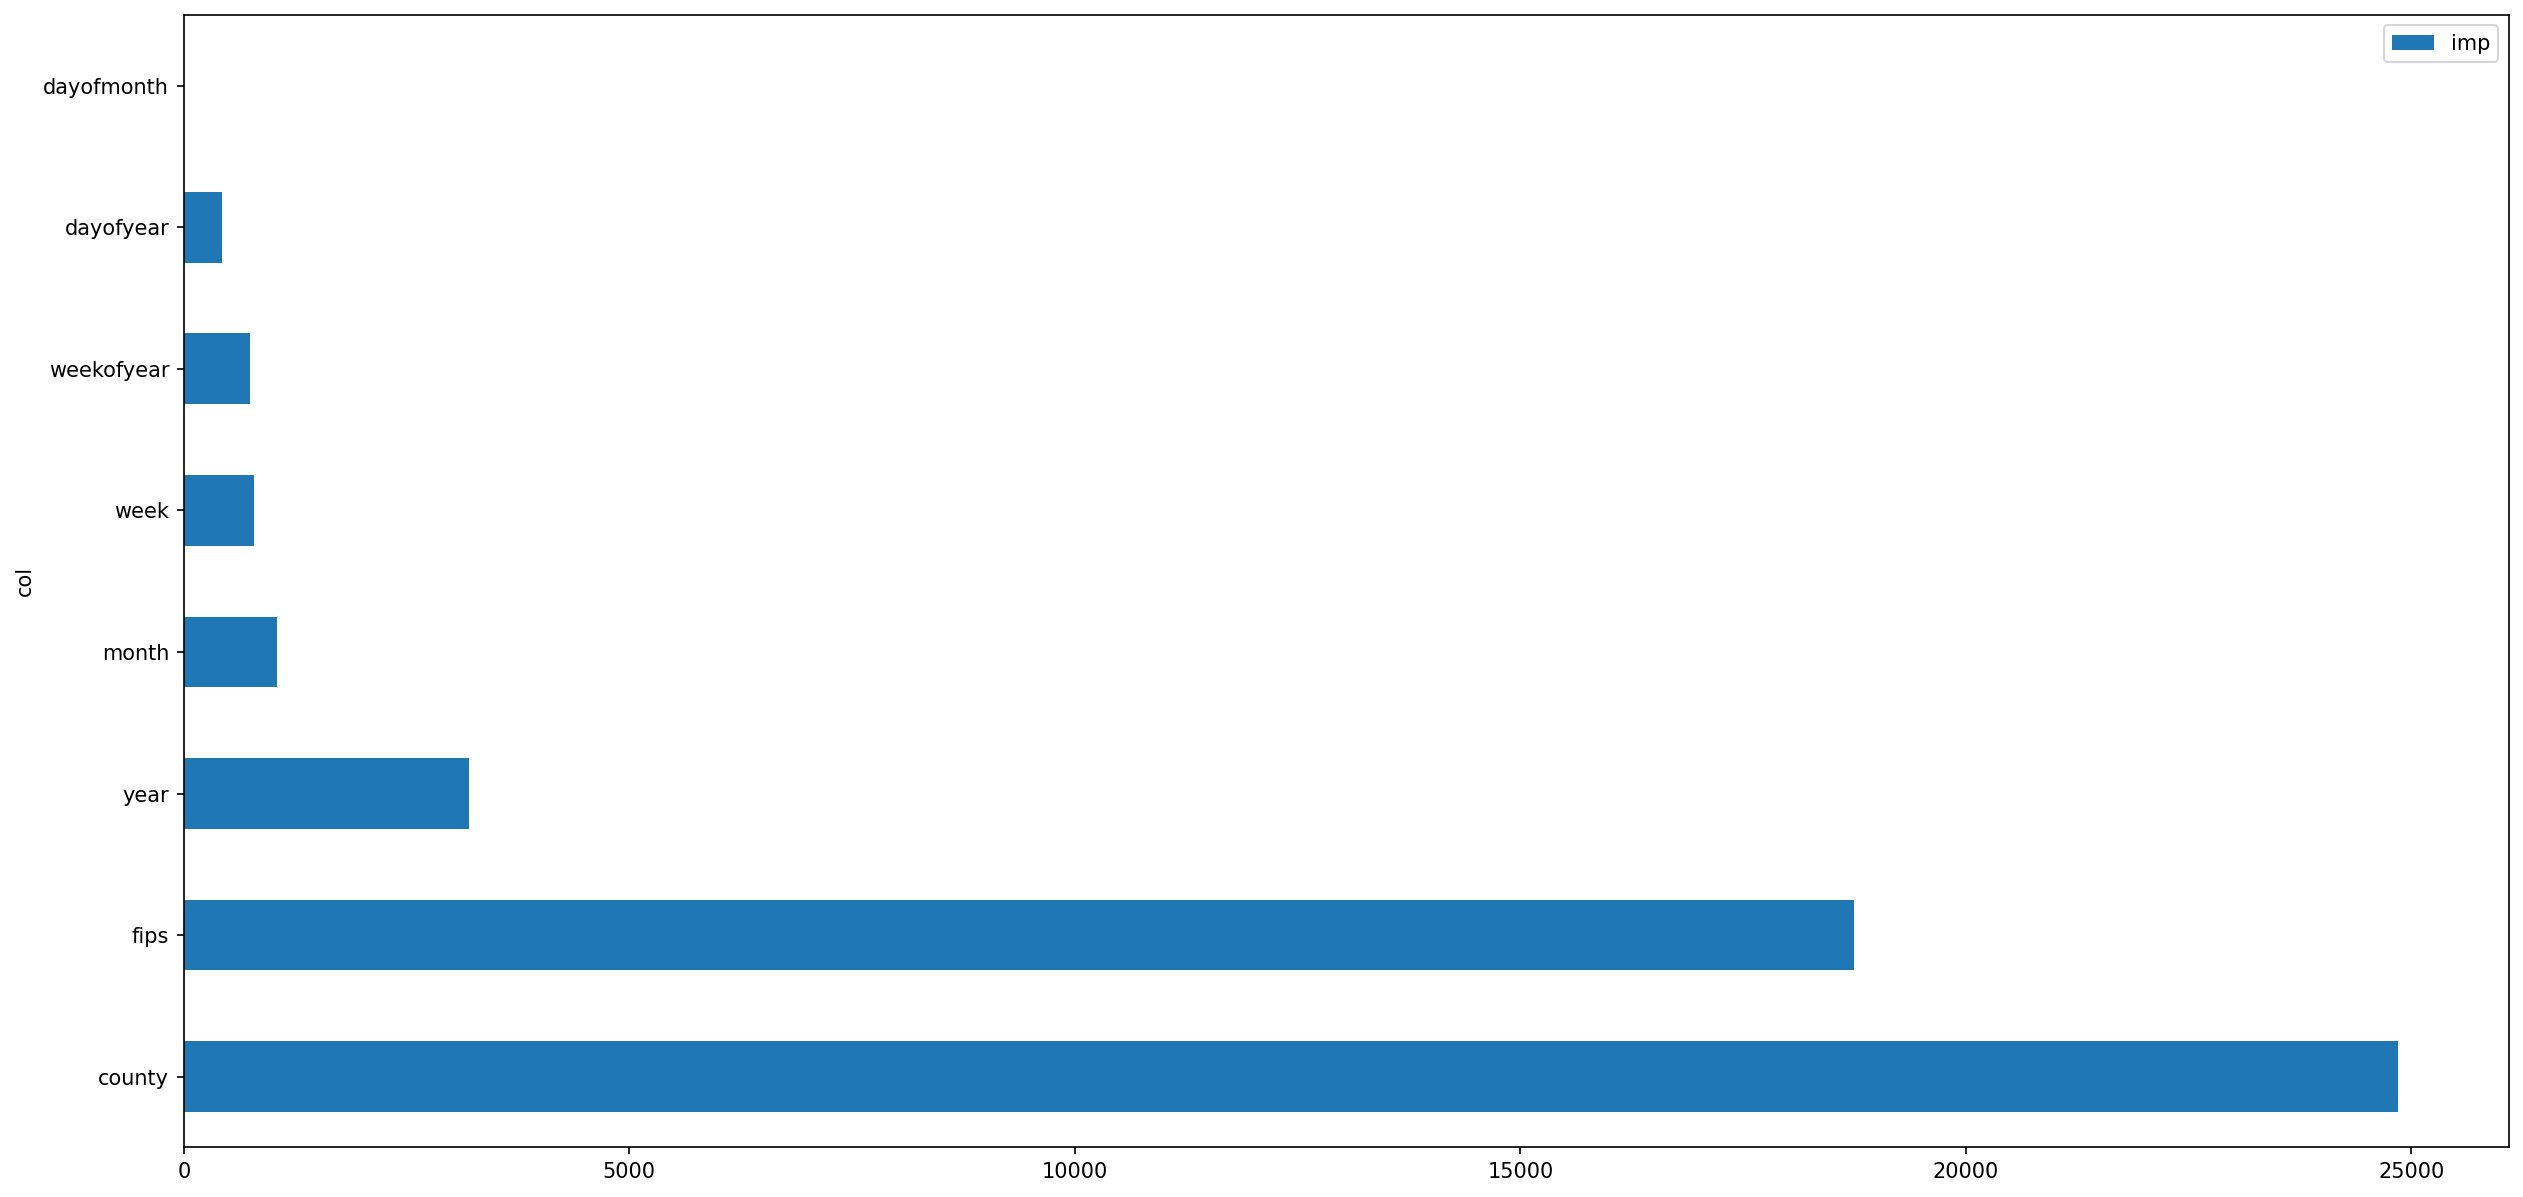

In [ ]:
#Checking feature importanca parameters of last run model
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

In [ ]:
# LightGbm V4
# LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

params = {
        "metric" : "mse",
        "learning_rate" : 0.2,
         "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
}

def create_feature(df):
    feature = pd.DataFrame()
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    feature['dayofyear'] = df['first_day_of_month'].dt.dayofyear
    feature['weekofyear'] = df['first_day_of_month'].dt.weekofyear
    
    return feature

train_v4 = create_feature(train)
test_v4 = create_feature(test)

X = train_v4
y = np.log1p(train['microbusiness_density'])


err_lgb_v4=[]
y_pred_lgb_v4=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_lgb_v4.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_v4)
    y_pred_lgb_v4.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.127764	valid_1's l2: 0.130423
[200]	training's l2: 0.0848812	valid_1's l2: 0.0873893
[300]	training's l2: 0.0603812	valid_1's l2: 0.0637127
[400]	training's l2: 0.0466206	valid_1's l2: 0.0500626
[500]	training's l2: 0.0384508	valid_1's l2: 0.0419666
[600]	training's l2: 0.0330007	valid_1's l2: 0.0365646
[700]	training's l2: 0.0287844	valid_1's l2: 0.0325517
[800]	training's l2: 0.0250104	valid_1's l2: 0.0289966
[900]	training's l2: 0.0230819	valid_1's l2: 0.0274575
[1000]	training's l2: 0.021603	valid_1's l2: 0.0263334
[1100]	training's l2: 0.0206845	valid_1's l2: 0.0258529
[1200]	training's l2: 0.0199751	valid_1's l2: 0.025618
[1300]	training's l2: 0.0192002	valid_1's l2: 0.0251185
[1400]	training's l2: 0.0186276	valid_1's l2: 0.0249093
[1500]	training's l2: 0.0181399	valid_1's l2: 0.0246777
[1600]	training's l2: 0.0177874	valid_1's l2: 0.0246575
Early stopping, best iteration is:
[1528]	training's l

In [ ]:
# XCB Regressor

# Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.
param = {
    'gamma': 10,
    'learning_rate': 0.2,
    'max_depth': 6,
    'n_estimators': 3000,
    'reg_alpha': 10,
    'subsample': 1.0
}

def create_feature(df):
    feature = pd.DataFrame()
    feature["fips"] = df["cfips"].astype(str).str[:2].astype(int)
    feature["county"] = df["cfips"].astype(str).str[2:].astype(int)
    feature["year"] = df["first_day_of_month"].dt.year
    feature["month"] = df["first_day_of_month"].dt.month
    feature["week"] = df["first_day_of_month"].dt.dayofweek
    feature['dayofyear'] = df['first_day_of_month'].dt.dayofyear
    feature['weekofyear'] = df['first_day_of_month'].dt.weekofyear
    
    return feature

train_xcb = create_feature(train)
test_xcb = create_feature(test)

X = train_xcb
y = np.log1p(train['microbusiness_density'])

err_xgb=[]
y_pred_xgb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = XGBRegressor(**param)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    err_xgb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_xcb)
    y_pred_xgb.append(p)

[02:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.891497	validation_1-rmse:0.890664
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.459696	validation_1-rmse:0.460181
Stopping. Best iteration:
[30]	validation_0-rmse:0.459696	validation_1-rmse:0.460174

err:  46.91845588727802
[02:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.891142	validation_1-rmse:0.893139
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.450759	validation_1-rmse:0.45092
Stopping. Best iteration:
[51]	validation_0-rmse:0.450759	validation_1-rmse:0.450

In [ ]:
np.mean(err_xgb)

46.80923855931476

In [ ]:
#Merging with census data

train_merged = train.merge(census,on=['cfips'])

In [ ]:
train_merged.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


In [ ]:
# Setting predictive and target variables

train_m1 = create_feature(train_merged)
test_m1 = create_feature(test)


train_m1['cfips'] = train['cfips']
test_m1['cfips'] = test['cfips']

train_m1['row_id'] = train['row_id']
test_m1['row_id'] = test['row_id']

test_id = test_m1['row_id']
tar_feat = train[['row_id', 'microbusiness_density']]

train_m1 = train_m1.merge(tar_feat, on=['row_id'])

train_m1.drop('row_id',axis=1,inplace=True)
test_m1.drop('row_id',axis=1,inplace=True)

print(train_m1.shape)
print(test_m1.shape)

(122265, 9)
(25080, 8)


In [ ]:
# Modelling on merged data frame

X = train_m1.drop('microbusiness_density', axis=1)
y = np.log1p(train_m1['microbusiness_density'])

params = {
        "metric" : "mse", 'num_leaves': 64,
        "sub_feature" : 1.0,
        "bagging_freq" : 1,
        "lambda_l2" : 0.9,
        'verbosity': 1,
       'num_iterations' : 3000,
    
}

errlgb=[]
y_pred_totlgb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=101)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",smape(np.expm1(y_test), np.expm1(preds)))
    errlgb.append(smape(np.expm1(y_test), np.expm1(preds)))
    p = m.predict(test_m1)
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 0.112044	valid_1's l2: 0.11608
[200]	training's l2: 0.0693022	valid_1's l2: 0.0734556
[300]	training's l2: 0.0459158	valid_1's l2: 0.0499668
[400]	training's l2: 0.032887	valid_1's l2: 0.0363252
[500]	training's l2: 0.0246722	valid_1's l2: 0.028119
[600]	training's l2: 0.0197789	valid_1's l2: 0.0230817
[700]	training's l2: 0.0161352	valid_1's l2: 0.0193656
[800]	training's l2: 0.0138516	valid_1's l2: 0.0170751
[900]	training's l2: 0.0122478	valid_1's l2: 0.0155365
[1000]	training's l2: 0.0111867	valid_1's l2: 0.0145195
[1100]	training's l2: 0.0103848	valid_1's l2: 0.0137889
[1200]	training's l2: 0.00967972	valid_1's l2: 0.0131526
[1300]	training's l2: 0.00914	valid_1's l2: 0.0127633
[1400]	training's l2: 0.00868416	valid_1's l2: 0.0124113
[1500]	training's l2: 0.00825797	valid_1's l2: 0.0120235
[1600]	training's l2: 0.00797465	valid_1's l2: 0.0118518
[1700]	training's l2: 0.00773312	valid_1's l2: 0.0117

In [ ]:
np.mean((errlgb))

7.747814389300895

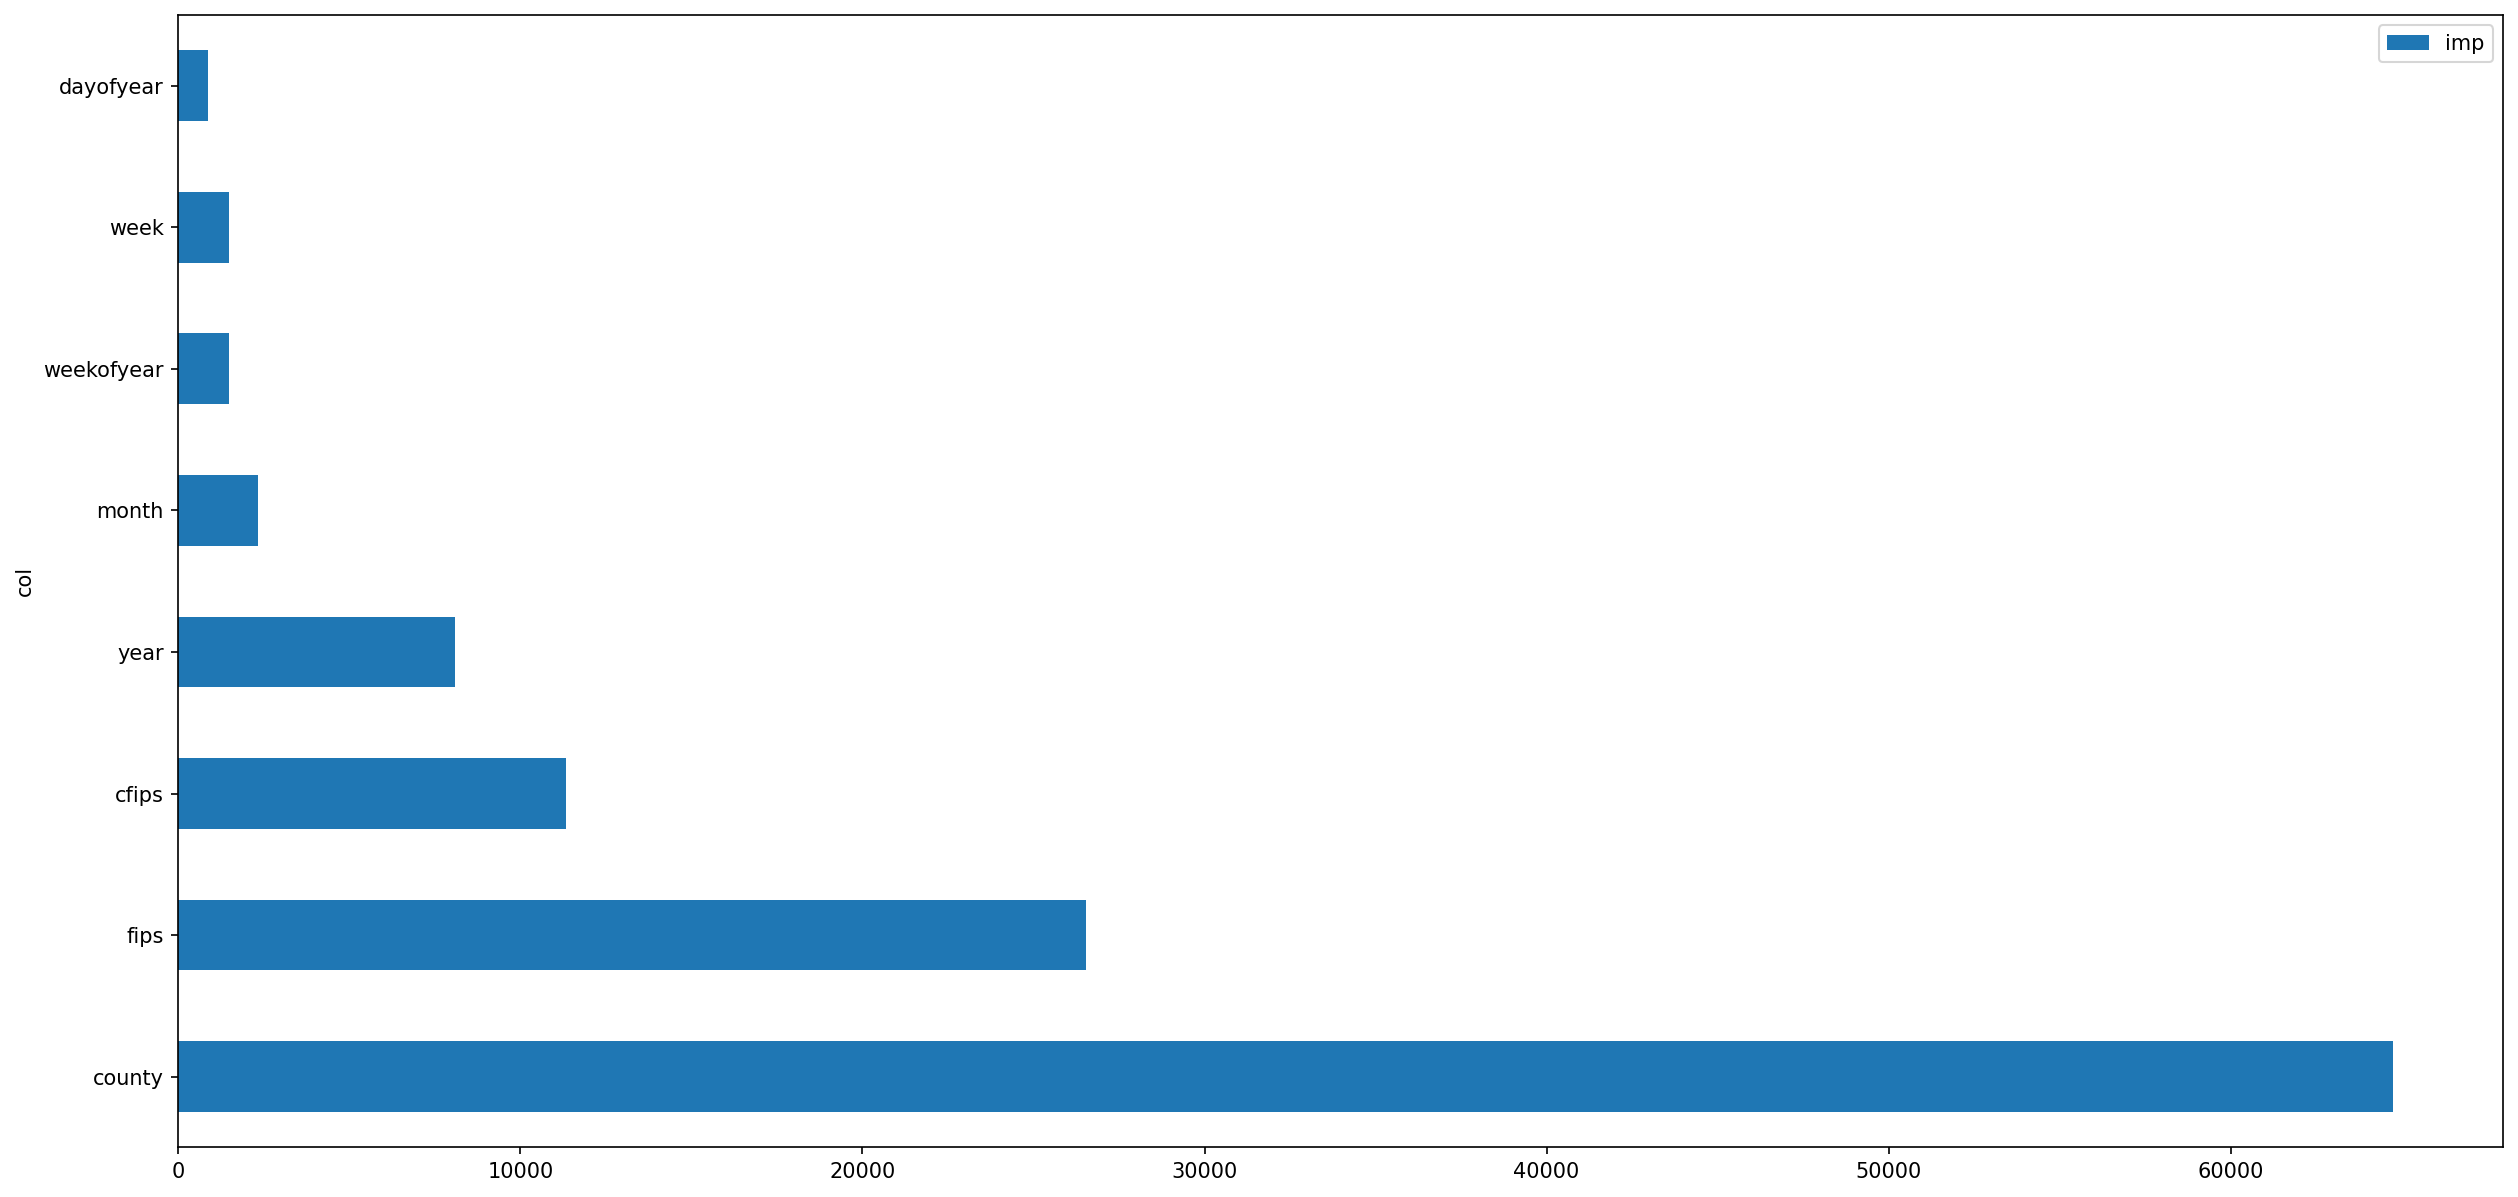

In [ ]:
#Checking feature importanca parameters of last run model
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

In [ ]:
#exporting submission
submission = {"row_id": test_id, 'microbusiness_density': abs(np.expm1(np.mean(y_pred_totlgb, 0)))}
sub_predictions = pd.DataFrame(data=submission)
sub_predictions = sub_predictions[["row_id", 'microbusiness_density']]



In [ ]:
sub_predictions.head(15)

,row_id,microbusiness_density
0,1001_2022-11-01,3.516714
1,1003_2022-11-01,7.848731
2,1005_2022-11-01,1.397436
3,1007_2022-11-01,1.285311
4,1009_2022-11-01,1.732041
5,1011_2022-11-01,1.151074
6,1013_2022-11-01,1.887392
7,1015_2022-11-01,2.933190
8,1017_2022-11-01,1.544589
9,1019_2022-11-01,1.240466


In [ ]:
sub_predictions.describe()

,microbusiness_density
count,25080.000000
mean,3.823176
std,4.612140
min,0.075423
25%,1.718269
50%,2.630763
75%,4.505117
max,128.756710
